In [1]:
from lisa.utils import *
from lisa.library import *
import lisa.models
import numpy as np, pandas as pd, datetime
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
datastream = DataSet.objects.get(id=6)
df = datastream.dataframe
print(df.shape)
df_res = pd.DataFrame(index=df.index, columns=df.columns)
df_mean = df.mean(axis=1)
df_std = df.std(axis=1)
df_quantile_25 = df.quantile(0.25, axis=1)
df_quantile_75 = df.quantile(0.75, axis=1)

(2016, 14)


In [4]:
count=0
for index, row in df.iterrows():
    for column in df.columns:
        IQR = df_quantile_75[index] - df_quantile_25[index]
        
        if row[column] < (df_quantile_25[index] - (1.5 * IQR)) or row[column] > (df_quantile_75[index] + (1.5 * IQR)):
            df_res.loc[index, column] = 1
            count+=1
            #print(index)
            #print('Val:', np.abs(row[column]))
            #print('Mean:', df_mean[index])
            #print('2 Std:', 2*df_std[index])
print(count)
print(df_res.sum(axis=0))

287
station
23      9.0
24     13.0
25     13.0
26      NaN
27     70.0
28      NaN
29     34.0
30      NaN
31      NaN
32      NaN
33      NaN
34      NaN
35    148.0
37      NaN
dtype: float64


In [5]:
indexes = []
for index, row in df_res.iterrows():
    for column in df_res.columns:
        if row[column] == 1:
            indexes.append(index)
            break
print(len(indexes))

222


In [6]:
df_class = pd.DataFrame(index=df.index)
df_class['Class'] = 0

for index in indexes:
    df_class.loc[index,'Class'] = 1
df = df.join(df_class)

In [7]:
normal = df[df['Class'] == 0]
anomaly = df[df['Class'] == 1]

In [8]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.5, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (897, 15)
Proportion os anomaly in training set: 0.00

Valid shape:  (559, 15)
Proportion os anomaly in validation set: 0.20

Test shape:,  (560, 15)
Proportion os anomaly in test set: 0.20



In [9]:
import tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(2)

batch_size = 10000

n_visible = train.drop('Class', axis=1).values.shape[1]
n_hidden1 = 27
n_hidden2 = 16
n_hidden3 = 2

learning_rate = 0.01

# create node for input data
X_tf = tf.placeholder("float", [None, n_visible], name='X')

# Paramtetrs initialization
W1_init = 4 * np.sqrt(6. / (n_visible + n_hidden1))
W2_init = 4 * np.sqrt(6. / (n_hidden1 + n_hidden2))
W3_init = 4 * np.sqrt(6. / (n_hidden2 + n_hidden3))

W1 = tf.Variable(tf.random_uniform([n_visible, n_hidden1],
                                   minval=-W1_init, maxval=W1_init), name='W1')
b1 = tf.Variable(tf.zeros([n_hidden1]), name='b1')

W2 = tf.Variable(tf.random_uniform([n_hidden1, n_hidden2],
                                   minval=-W2_init, maxval=W2_init), name='W2')
b2 = tf.Variable(tf.zeros([n_hidden2]), name='b2')

W3 = tf.Variable(tf.random_uniform([n_hidden2, n_hidden3],
                                   minval=-W3_init, maxval=W3_init), name='W3')
b3 = tf.Variable(tf.zeros([n_hidden3]), name='b3')

W3_prime = tf.Variable(tf.random_uniform([n_hidden3, n_hidden2],
                                   minval=-W3_init, maxval=W3_init), name='W3_prime')  
b3_prime = tf.Variable(tf.zeros([n_hidden2]), name='b3_prime')

W2_prime = tf.Variable(tf.random_uniform([n_hidden2, n_hidden1],
                                   minval=-W2_init, maxval=W2_init), name='W2_prime')  
b2_prime = tf.Variable(tf.zeros([n_hidden1]), name='b2_prime')

W1_prime =  tf.Variable(tf.random_uniform([n_hidden1, n_visible],
                                   minval=-W1_init, maxval=W1_init), name='W1_prime')
b1_prime = tf.Variable(tf.zeros([n_visible]), name='b1_prime')


def autoencoder(X_tf):
    
    # encoder
    Y = tf.nn.tanh(tf.matmul(X_tf, W1) + b1)  
    Y = tf.nn.tanh(tf.matmul(Y, W2) + b2) 
    Y = tf.nn.tanh(tf.matmul(Y, W3) + b3) 
    
    # decoder
    Z = tf.nn.tanh(tf.matmul(Y, W3_prime) + b3_prime)
    Z = tf.nn.tanh(tf.matmul(Z, W2_prime) + b2_prime)  
    Z = tf.nn.tanh(tf.matmul(Z, W1_prime) + b1_prime)
    
    return Z, Y

Z, Y = autoencoder(X_tf)

cost = tf.reduce_mean(tf.pow(X_tf - Z, 2))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
scores = tf.abs(X_tf - Z)

X_train = train.drop('Class', axis=1).values
X_val_norm = valid[valid['Class'] == 0].drop('Class', axis=1).values
X_val_anorm = valid[valid['Class'] == 1].drop('Class', axis=1).values


In [10]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()

    for step in range(15001):
        
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]

        sess.run(train_op, feed_dict={X_tf: batch_data,})
        
        if (step % 3000 == 0):
            print('\nBatch loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: batch_data})))
            print('Val Norm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_norm})))
            print('Val Anorm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_anorm})))
        
    y_scores_valid, enc_val = sess.run([scores, Y], feed_dict={X_tf: valid.drop('Class', axis=1).values})
    df_n = df.reset_index(drop=True)
    y_scores_test, enc_test = sess.run([scores, Y], feed_dict={X_tf: df_n.drop('Class', axis=1).values})


Batch loss at step 0: 444.752625
Val Norm loss at step 0: 440.803497
Val Anorm loss at step 0: 403.865356

Batch loss at step 3000: 397.315430
Val Norm loss at step 3000: 393.656799
Val Anorm loss at step 3000: 362.338562

Batch loss at step 6000: 397.315369
Val Norm loss at step 6000: 393.656799
Val Anorm loss at step 6000: 362.338531

Batch loss at step 9000: 397.315369
Val Norm loss at step 9000: 393.656799
Val Anorm loss at step 9000: 362.338531

Batch loss at step 12000: 397.315369
Val Norm loss at step 12000: 393.656799
Val Anorm loss at step 12000: 362.338531

Batch loss at step 15000: 397.315369
Val Norm loss at step 15000: 393.656799
Val Anorm loss at step 15000: 362.338531


In [13]:
tresholds = np.linspace(10, 25, 100)

scores = []
for treshold in tresholds:
    y_hat = (y_scores_valid.mean(axis=1) > treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.334841628959 27


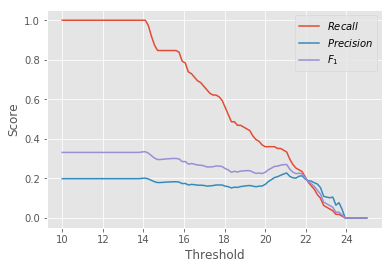

In [14]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

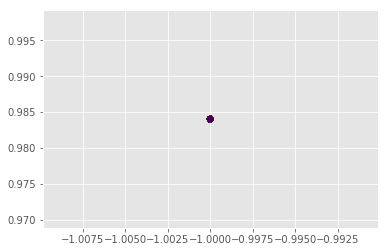

In [15]:
plt.scatter(enc_val[:, 0], enc_val[:, 1], c=valid["Class"].values, alpha=.5)
plt.show()

Final threshold: 14.091
Test Recall Score: 1.000
Test Precision Score: 0.111
Test F1 Score: 0.200


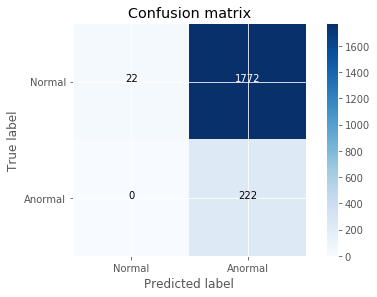

In [17]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (y_scores_test.mean(axis=1) > final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

Final threshold: 13.939
Test Recall Score: 1.000
Test Precision Score: 0.199
Test F1 Score: 0.332


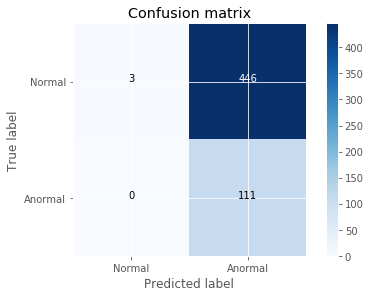

In [25]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (y_scores_test.mean(axis=1) > final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=1))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')